# Neural Network (Classification)

[Naive implementation](#naive-implementation)  
[Using Keras](#Using-Keras)  
[Using Pytorch](#Using-Pytorch)  
[Using Tensorflow](#Using-Tensorflow)

## The data

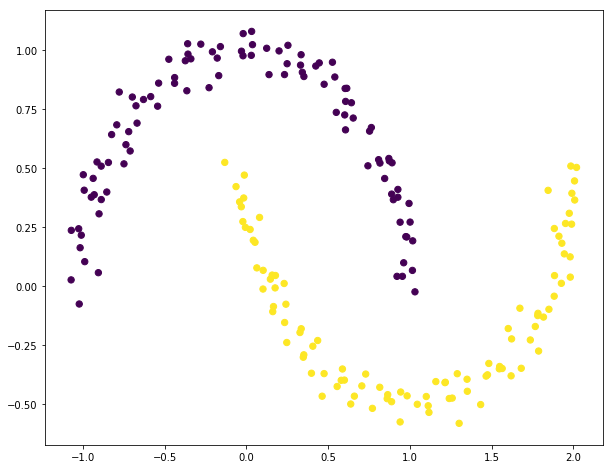

In [3]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
from mlxtend.plotting import plot_decision_regions


# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.05)
plt.scatter(X[:, 0], X[:, 1], s=40, c=y)

# one-hot encoding
y_train = np.zeros((y.size, 2))
y_train[range(len(y)), y] = 1
X_train = X

## Naive Implementation

In [4]:
from sklearn.neural_network._base import softmax

alpha = 0.01
lambda_ = 0.01


def _feed_forward(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    o = softmax(z2)
    return o, {"z1": z1, "a1": a1, "z2": z2}

    
def predict(model, X):
    output, _ = _feed_forward(model, X)
    return np.argmax(output, axis=1)

def loss_function(model, X, y):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    o, _ = _feed_forward(model, X)
    
    reg_term = lambda_/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2))) 
    data_loss = np.sum(-np.log(o[range(len(X)), y]))
    data_loss += reg_term
    data_loss = data_loss / X.shape[0]
    
    return data_loss
    

def train_model(X, y, hidden_size, epochs=20000):
    input_size = X.shape[1]
    output_size = 2
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
    b2 = np.zeros((1, output_size))
    
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    for i in range(0, epochs):
        o, cache = _feed_forward(model, X)
        
        # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
        # delta3 = o - y
        delta3 = o
        delta3[range(len(X)), y] -= 1
        delta2 = delta3.dot(W2.T) * (1 - np.power(cache["a1"], 2))
                
        dW2 = cache["a1"].T.dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        dW2 += lambda_ * W2
        dW1 += lambda_ * W1
        
        W2 += -alpha * dW2
        W1 += -alpha * dW1
        b2 += -alpha * db2
        b1 += -alpha * db1
        
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        if i % 1000 == 0:
            print("Epoch: %04d" % i, loss_function(model, X, y))
            # print(b2, b1)
        
    return model


Epoch: 0000 0.41886789635417593
Epoch: 1000 0.004859957006923416


Epoch: 2000 0.004636019624475354


Epoch: 3000 0.004600056169688691


Epoch: 4000 0.004587661735283828
Epoch: 5000 0.004581521801568179


Epoch: 6000 0.004577938361415669
Epoch: 7000 0.004575660955264387


Epoch: 8000 0.004574131562016374
Epoch: 9000 0.004573061985719588


Epoch: 10000 0.004572290285201873
Epoch: 11000 0.004571719846949773


Epoch: 12000 0.004571290139587795
Epoch: 13000 0.004570961614166063


Epoch: 14000 0.004570707486398872
Epoch: 15000 0.0045705090586366


Epoch: 16000 0.004570352944502105
Epoch: 17000 0.004570229357777641


Epoch: 18000 0.00457013101955691
Epoch: 19000 0.004570052437797104


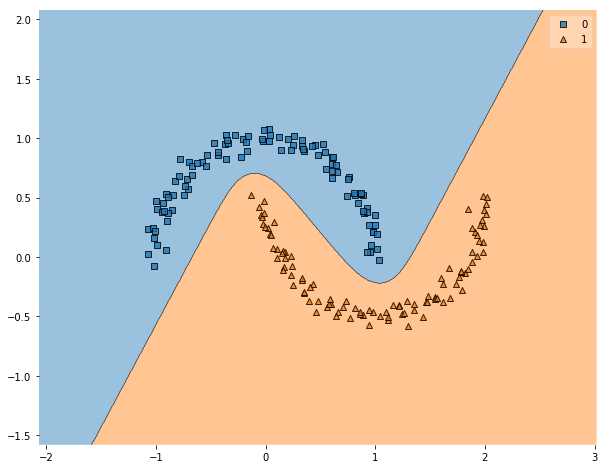

In [5]:
hidden_size = 3
model = train_model(X, y, hidden_size)

# a dummy class to "do the trick" with 'plot_decision_regions'
class Classifier():

    def predict(self, X):
        return predict(model, X)
    

plot_decision_regions(X, y, clf=Classifier())

## Using Keras

In [6]:
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from keras import optimizers
from keras.layers import Dense, Softmax


input_size = 2
hidden_size = 3
output_size = 2
learning_rate = 0.05

model = keras.Sequential()
model.add(Dense(hidden_size, input_dim=input_size, use_bias=True, 
                kernel_initializer=keras.initializers.glorot_normal(seed=None),
                bias_initializer="zeros", activation="tanh"))
model.add(Dense(output_size, use_bias=True, 
                kernel_initializer=keras.initializers.glorot_normal(seed=None), 
                bias_initializer="zeros"))
model.add(Softmax(output_size))


sgd = optimizers.SGD(lr=learning_rate)
model.compile(sgd, loss="binary_crossentropy")
model.summary()

history = model.fit(X, y_train, epochs=2000, verbose=0)
print("last loss: ", history.history["loss"][-1])

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 8         
_________________________________________________________________
softmax_1 (Softmax)          (None, 2)                 0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


last loss:  0.024302844181656836


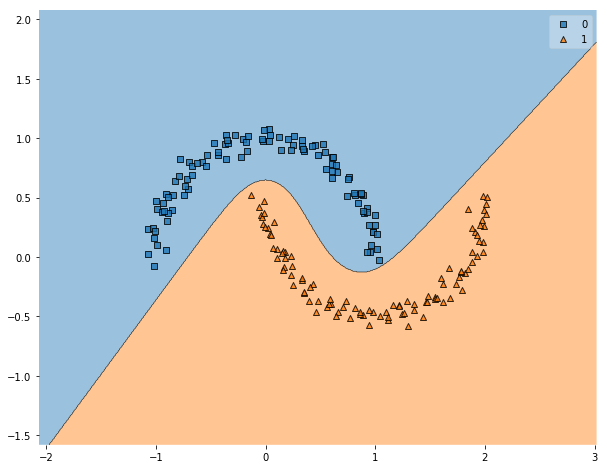

In [8]:
class Wrapper():
    def predict(self, X):
        y_pred = model.predict(X)
        y = np.argmax(y_pred, axis=1)
        return y
    
plot_decision_regions(X, y, clf=Wrapper())

## Using Pytorch


Epoch: 00000 0.5364460349082947


Epoch: 01000 0.4231944978237152


Epoch: 02000 0.3138473629951477


Epoch: 03000 0.3134624660015106


Epoch: 04000 0.31335583329200745


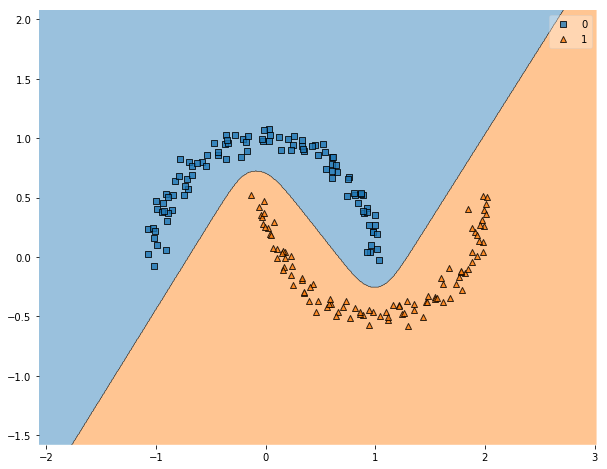

In [69]:
import torch

# device = torch.device('cpu')
device = torch.device('cuda')

input_size = 2
hidden_size = 3
output_size = 2
learning_rate = 0.01
epochs = 5000

model = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden_size, output_size),
    torch.nn.Softmax(1)
)

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


model.apply(init_weights)


def train_model(model, X, y, epochs=epochs):
    # Create Tensors to hold inputs and outputs
    X_torch = torch.FloatTensor(X, device=device)
    y_torch = torch.LongTensor(y, device=device)
    
    loss_f = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for i in range(epochs):
        
        y_pred = model(X_torch)
        
        current_loss = loss_f(y_pred, y_torch)
        # zero the gradients
        optimizer.zero_grad()
        # compute gradient of the loss wrt weights
        current_loss.backward()
        # update parameters
        optimizer.step()
        
        if i % 1000 == 0:
            print("Epoch: %05d" % i, current_loss.item())
            
    return model


model = train_model(model, X_train, y)

class Wrapper:
    
    def __init__(self, pytorch_model):
        self.model = pytorch_model
    
    def predict(self, X):
        X_torch = torch.FloatTensor(X, device=device)
        y = self.model(X_torch)
        y_pred = np.argmax(y.detach().numpy(), axis=1)
        return y_pred
    

plot_decision_regions(X_train, y, clf=Wrapper(model))

Epoch: 00000 0.7907717823982239


Epoch: 01000 0.424686461687088


Epoch: 02000 0.31464049220085144


Epoch: 03000 0.31364497542381287


Epoch: 04000 0.31343233585357666


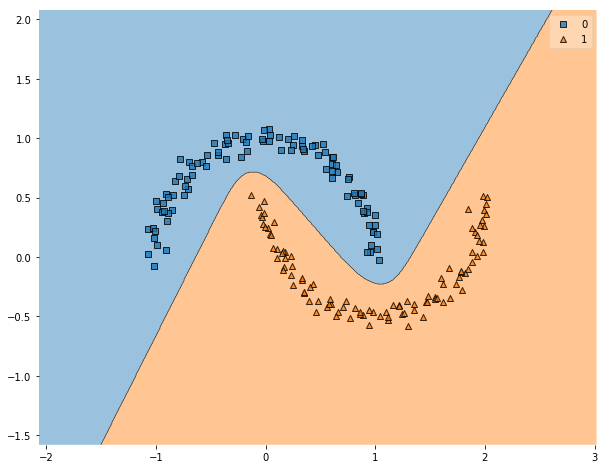

In [70]:
# Module version

class MyNet(torch.nn.Module):
    
    def __init__(self):    
        super().__init__()
        self.input_layer = torch.nn.Linear(input_size, hidden_size)
        self.hidden_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        hidden = torch.nn.Tanh()(self.input_layer(x))
        output = torch.nn.Softmax(1)(self.hidden_layer(hidden))
        return output
        
model = MyNet()
model = train_model(model, X_train, y)

plot_decision_regions(X_train, y, clf=Wrapper(model))

## Using Tensorflow

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



loss at 0:  0.83619386


loss at 1000:  0.038119487


loss at 2000:  0.034671538


loss at 3000:  0.03389572


loss at 4000:  0.033676583


final loss:  0.033636477


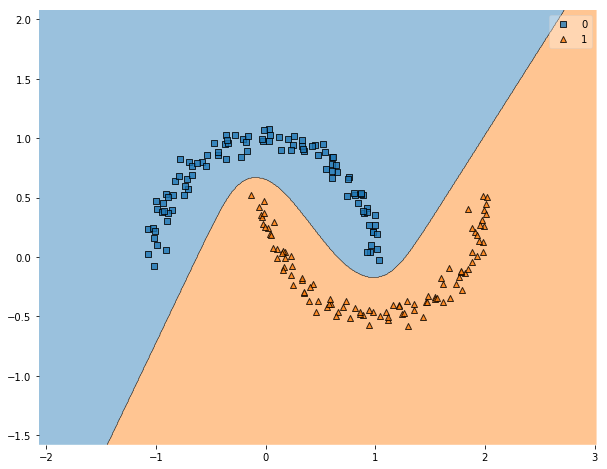

In [9]:
import tensorflow as tf

learning_rate = 0.01 
lambda_ = 0.001

X_train = X
# one-hot encoding
y_train = np.zeros((y.shape[0], 2))
y_train[np.arange(y.shape[0]), y] = 1

input_size = 2
hidden_size = 3
output_size = 2
epochs = 5000

Xtf = tf.placeholder(tf.float32, [None, input_size])
Ytf = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal((input_size, hidden_size)))
W2 = tf.Variable(tf.random_normal((hidden_size, output_size)))
b1 = tf.Variable(tf.random_normal((hidden_size, )))
b2 = tf.Variable(tf.random_normal((output_size, )))

l_input = tf.add(tf.matmul(Xtf, W1), b1)
l_input = tf.nn.tanh(l_input)
l_output = tf.matmul(l_input, W2) + b2

regularization_term = lambda_/2 * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(b1) + tf.nn.l2_loss(b2))
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=l_output, labels=Ytf))
cost = tf.add(cost, regularization_term)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(epochs):
        sess.run(optimizer, feed_dict={Xtf: X_train, Ytf: y_train})
        current_loss = sess.run(cost, {Xtf: X_train, Ytf: y_train})
        
        if i % 1000 == 0:
            print("loss at %d: " % i, current_loss)
        
    print("final loss: ", sess.run(cost, {Xtf: X_train, Ytf: y_train}))
    
    class Wrapper:
        
        def predict(self, X):
            output = sess.run(l_output, feed_dict={Xtf: X})
            return np.argmax(output, axis=1)
        
    plot_decision_regions(X_train, y, clf=Wrapper())